# Deep Learning for Business Applications course

## TOPIC 11: Classical methods of machine learning in natural language processing (NLP)

### 1. Understanding the goal

Today we are going to build a simple text classifier.  
Suppose we own a big online shop and our customers are able to write a feedback and rate products after the purchase from 1 to 5:

1. awfull
2. not very nice
3. normal
4. nice
5. awesome

Some of our customers wrote a feedback but decided not to rate a product. Suppose one of the shop KPIs is a percentage of a nice and awesome products that we sold to our customers. We can simply calculate this KPI using avaliable rates. Let's define:

$$good=\#4 + \#5$$
$$bad=\#1 + \#2 + \#3$$

where $\#A$ means "count of $A$ rate", $A=\overline{1,5}$.  
Then KPI will be:

$$KPI = \frac{good}{good + bad}$$

We read sample of rate comments and figured out that sentiment of the feedback correlated with rate, in other words if customer satisfied with the product the rate is hight and vice versa.

Knowing that, can we somehow improve estimation of the KPI using feedback of the unrated products? Yes, of course. We can build a binary classifier which takes feedback as an input and predicts probability of a good product:
$$p=p(x, θ)=P(y = 1|x, θ),$$
were $x$ is a feedback, $θ$ is a model weights, and $y$ is binary variable that takes two values: $1$ —  product is good and $0$ — product is bad.  

Probability of a bad product will be:
$$P(y = 0|x, θ) = 1 - P(y = 1|x, θ) = 1 - p(x, θ) = 1 - p$$

If we know $p$ how to go from it to classes? We should choose probability threshold $t$:
* If $p >= t$ then $y=1$ witch means it's a good product.
* If $p < t$ then $y=0$ witch means it's a bad product.

We are going to use binary cross entropy loss for training as usual:

$$L(x, θ) = -\sum_{i=1}^{m}{y_i log(p_i) + (1-y_i)log(1-p_i)}$$

where $m$ is a count of texts in the training set, $y_i$ is a target label of text $i$ and $p_i$ is a probability of text $i$ is good predicted by a classifier.

Gradient descent is already implemented in sklearn.

In this work we will be using data from this resource: http://jmcauley.ucsd.edu/data/amazon/

### 2. Data exploration

First of all, let's look at the data

In [ ]:
%%bash
REVIEW_NAME="reviews_Clothing_Shoes_and_Jewelry_5.json"
wget -q -nc "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/$REVIEW_NAME.gz"
if [ ! -f $REVIEW_NAME ]; then
    gzip -dk $REVIEW_NAME;
fi

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

In [ ]:
data_path = "/home/jovyan/__DATA/DLBA_F25/topic_11"
reviews = pd.read_json(
    f"{data_path}/reviews_Clothing_Shoes_and_Jewelry_5.json", 
    lines=True
)
reviews.head()

Our data contains three usefull columns:

* `reviewText` − customer feedback
* `summary` − short summary of customer feedback
* `overall` − rate of product

We could build two classifiers with `summary` and `reviewText` as input text respectively, but to simplify our life we can concatenate them as if `summary` is a first sentense of customer feedback.

In the next cell write a code which concatenates strings in columns `summary` and `reviewText` separated by space and assign the result to a new column `text`.

In [ ]:
reviews['text'] = reviews['summary'] + ' ' + reviews['reviewText']
reviews.head()

Let's look at the distribution of rates.  
Create a new dataframe `rating_dist` with two columns:
* `overall` - unique rates from 1 to 5
* `count` - count of rates in our `reviews` dataframe

Describe the resulting pie chart.

In [ ]:
rating_dist = reviews \
    .groupby('overall')[['overall']] \
    .count() \
    .rename(columns={'overall': 'count'}) \
    .reset_index()

px.pie(
    rating_dist, 
    names='overall', 
    values='count', 
    title='Ratings distribution', 
    width=640, height=480, 
    template='plotly_dark'
)

### 3. Analysis of the target variable

It's time to calculate our target variable.  
Recall that $y=1$ means the product is good and $y=0$ means the product is bad. Good products have rates 4, 5 and bad products have rates 1, 2, 3.

Add a new column `target` to `reviews` dataframe following the above logic.

Then create a new dataframe `rating_dist` again with two columns:
* `target` - unique values 0 and 1
* `count` - count of rates in our `reviews` dataframe

Look at the pie chart. What can you say about class balance? Can it cause the problem?

In [ ]:
reviews['target'] = np.where(reviews['overall'] < 4, 0, 1)

rating_dist = reviews \
    .groupby('target')[['target']] \
    .count() \
    .rename(columns={'target': 'count'}) \
    .reset_index()

px.pie(
    rating_dist, 
    names='target', 
    values='count', 
    title='Target distribution', 
    width=640, height=480, 
    template='plotly_dark'
)

### 4. Deal with balance

There are different approaches to deal with imbalanced classes: adding the weights of classes in our loss function, make upsampling, make downsampling, generate synthetic data of minority class etc.

In this work we will use downsampling. It is a very simple technique. We have 20.5% reviews from class "0" and 79.5% examples from class "1". We will remove some objects from class "1" so that the class balance is 50/50.

Find out how many objects in class "0" we have and sample the same amount of objects from class "1". Set parameter `random_state=0` to make sampling reproducible. Then combine objects from class "0" and resulting sample to one dataset `data`.

In [ ]:
rating_dist

In [ ]:
bad_counts = rating_dist[rating_dist['target'] == 0]['count'][0]

good_reviews = reviews[reviews['target'] == 1].sample(bad_counts, random_state=0)
bad_reviews = reviews[reviews['target'] == 0]

data = pd.concat([good_reviews, bad_reviews], ignore_index=True)

print('Data shape:', data.shape)
display(data.head(5), data.tail(5))

### 5. Tokenization approaches

#### 5.1. Bag of words model

To build a binary clissifier we need binary target variable that we already calculated and input features. So, somehow we need to extract features from the text of feedback. Let's create a vector representations of each text. The simplest way to do it is a bag-of-words model (BOW). The BOW assumes that text can be represented of its words and disregarding word order. Word is a feature in this model and frequency of particular word in the text is the value of the featur. It means that to make a vector representations we need to create a vocabulary of all words in the corpus and count of each word in each text.

For example, if we have a corpus of two lowercase texts:
* "this product is awesome. product has awesome functions."
* "this product is disgusting. it does not work"

then vector representation will look like this:

<table>
  <tr>
    <th>this</th> <th>product</th> <th>is</th> <th>awesome</th> <th>.</th>
    <th>has</th> <th>functions</th> <th>disgusting</th> <th>it</th>
    <th>does</th> <th>not</th> <th>work</th>
  </tr>
  <tr>
    <td>1</td> <td>2</td> <td>1</td> <td>2</td> <td>2</td> <td>1</td> <td>1</td>
    <td>0</td> <td>0</td> <td>0</td> <td>0</td> <td>0</td>
  </tr>
  <tr>
    <td>1</td> <td>1</td> <td>1</td> <td>0</td> <td>1</td> <td>0</td> <td>0</td>
    <td>1</td> <td>1</td> <td>1</td> <td>1</td> <td>1</td>
  </tr>
</table>

Instead of count we can calculate the term frequency (TF):

$$TF(text, word) = \frac{n_k}{\sum_{k} n_k}$$

where $n_k$ is count of partiqular word in the document and $\sum_{k} n_k$ is the count of all words in document.

You can consider this transformation as a type of scaling. Input vectors will be look like this:

<table>
  <tr>
    <th>this</th> <th>product</th> <th>is</th> <th>awesome</th> <th>.</th>
    <th>has</th> <th>functions</th> <th>disgusting</th> <th>it</th>
    <th>does</th> <th>not</th> <th>work</th>
  </tr>
  <tr>
    <td>0.1</td> <td>0.2</td> <td>0.1</td> <td>0.2</td> <td>0.2</td>
    <td>0.1</td> <td>0.1</td> <td>0.0</td> <td>0.0</td> <td>0.0</td>
    <td>0.0</td> <td>0.0</td>
  </tr>
  <tr>
    <td>0.11</td> <td>0.11</td> <td>0.11</td> <td>0.0</td> <td>0.11</td>
    <td>0.0</td> <td>0.0</td> <td>0.11</td> <td>0.11</td> <td>0.11</td>
    <td>0.11</td> <td>0.11</td>
  </tr>
</table>

Another improvement we can make is to reduce the weights of commonly used words.
Let's calculate weight of each word like this:

$$IDF(word) = log(\frac{N}{df_w})$$

where $N$ is a count of documents(texts) in the corpus and $df_w$ is a count of documents containing word $w$.

If some word occurs in all documents then $IDF = log(\frac{N}{N}) = 0$.

The final feature is called TF-IDF and calculated like this:

$$TF\text{-}IDF = TF * IDF$$

#### 5.2. N-gram model

Disregarding word order can cause a problem. Suppose we have texts:
* "This product is nice."
* "This product is not nice."

Vectors of this two texts will be very close in BOW feature space and model can predict that both products is good. To avoid this problem we can use pair of words 'not nice' as a feature insted of just separate words 'not' and 'nice'. Pair of two words in text called a bigram. For example, we can write all bigrams of second sentence:  

`['This product', 'product is', 'is not', 'not nice']`  

The common model is called n-gram, that contains sequences of n words as a features. For example, `nice` is unigram(word), `product is not` is a 3-gram, `This product is not` is a 4-gram.

We can union unigrams, bigrams, threegrams etc. to create a dataset for a better model. Frequencies of n-grams is calculated the same way as frequency of words.

But be careful and don't add a lot of different n-grams. It can cause overfitting. Here we can draw an analogy with adding polynomial features in a model when we work with tabular data.


### 6. Texts Preprocessing

Now let's prepare our corupus to modeling.

The first thing that we should do is to clean each text from trash. It can be special unicode symbols, characters like @#$% inside words, etc. An approach of cleaning is always different for each task. In our case we will be following the hypotesis that rates depend on words in feedback and no punctuation symbols have influence on rates. So we will remove everything except letters.

The second step is tokenization. We should split each text into words.

After tokenization we may figure out that our courpus contains a lot of the same words but in different forms. For example:
`['walk', 'walking', 'walked']` or `['go', 'went', 'gone']`.
It will increase volume of our feature space because all of this words is a feature. To reduce dimension we can use stemming or lemmatization.

Stemming is the process of reducing inflected words to their word base. For example, `walk` is the base of word `walking`. Stemmer will remove prefixes or suffixex of word, in this case `-ing` suffix.

Lemmatization is the process of converting an inflected word to its normal form.
For example, `go` is a normal form of `went`.

Last step is a removing a stop words. Stop word is a very common words in language like prepositions, particles, articles etc.

It is not a full list of preprocessing steps but it will be sufficient for this work.

In [ ]:
# Download some necessary packages for nltk
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

In [ ]:
# import packages for preprocessing text
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from functools import lru_cache
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
# for beautiful progress bar
tqdm.pandas()

In [ ]:
stopwords_set = set(stopwords.words('english'))  # get a set of stopwords
cleaner = re.compile('[^A-Za-z \']')  # regular expression for cleaning text
stemmer = SnowballStemmer('english')  # for stemming

In [ ]:
# Use this function to stem a word(token). It works much faster because
# it saves each word and result in cache and doesn't do stemming if the
# word has been seen already.
@lru_cache(maxsize=None)
def stem(token):
    return stemmer.stem(token)

# Implement following steps:
# - replace all trash symbols to spaces.
# - convert the string to lowercase.
# - tokenize a string using function word_tokenize(...).
# - stem each token and if it's not a stop word add token to list `lem_tokens`
def preprocess(text):
    string = cleaner.sub(' ', text)
    tokens = word_tokenize(string.lower(), language='english')
    lem_tokens = []
    for token in tokens:
        l_token = stem(token)
        if l_token not in stopwords_set:
            lem_tokens.append(l_token)
    return ' '.join(lem_tokens)

In [ ]:
%%time
# run preprocess for each text
data['bow'] = data['text'].progress_apply(preprocess)

In [ ]:
data["bow"]

In [ ]:
# create input and target
X = data['bow']
y = data['target']

# split dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1992)

In [ ]:
y_train

In [ ]:
# import class TfidfVectorizer that transform our texts to vectors
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Create a TfidfVectorizer object with unigrams and bigrams and use parameters
# min_df to ignore n-grams that appear in fewer than 15 documents
# and max_df to ignore n-grams that appear in more than 70% documents.
tfidf_vec = TfidfVectorizer(ngram_range=(1, 2), min_df=15, max_df=0.7)

# Use method `fit_transform` to train TfidfVectorizer and return TF-IDF features
# from training set
X_train_tfidf = tfidf_vec.fit_transform(X_train)

# Use method `transform` to return TF-IDF features
# from test set
X_test_tfidf = tfidf_vec.transform(X_test)

# DO NOT MODIFY CODE BELOW
print(X_train_tfidf.shape, X_test_tfidf.shape)

### 7. Logistic regression model
Now we can train a classifier. There are a lot of classification algorithms in ML but its better to start from something simple because simple model can get acceptable results and it will work very fast.

In this work we are going to use logistic regression. The model has the following form:

$$p(x, θ) = sigmoid(\sum_{k=1}^{n} θ_kx_k)$$

where $n$ is count of features, $x_k$ is value of feature $k$ and $θ_k$ is a weight of feature $k$ and $sigmoid(z) = \frac{1}{1 + exp(-z)}$.

Actually, it is a very simple neural network called perceptron.

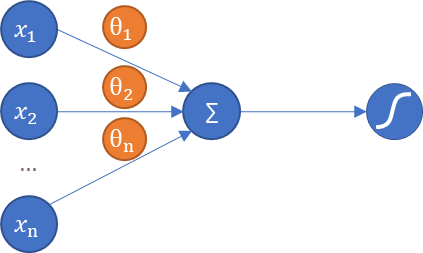


In [ ]:
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
%%time
# We create model with following parameters:
# - Cs=10 means that algorithm will use 10 differen regularization 
#   coefficient and choose the best according to the scoring metric.
# - cv=5 means that algorithm will do 5-fold cross validation.
# - penalty='l2' means algorithm will use l2 norm for regularization.
# - scoring='roc_auc' is a scoring metric that changes from 0 to 1. 
#   1 means ideal classifier, 0.5 - random classifier. 
#   We should get something between.

model = LogisticRegressionCV(
    Cs=10, 
    cv=5, 
    penalty='l2', 
    scoring='roc_auc', 
    solver='saga', 
    max_iter=100, 
    random_state=0, 
    n_jobs=-1
)

# Fit model on train data and predict probabilities on test set.
model.fit(X_train_tfidf, y_train)
p_test = model.predict_proba(X_test_tfidf)

# Look at the first 5 probabilities
print(p_test[:5, 1])

### 8. Model quality
To estimate our model we will look at the ROC-curve and ROC-AUC metric. Recall that ROC-curve reflects the dependence of true positive rate from false positive rate and the more area under the curve the better. What can you say about our model? Is it acceptable? Is it overfitted?

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(5, 5))

RocCurveDisplay.from_estimator(model, X_train_tfidf, y_train, ax=ax, label="train")
RocCurveDisplay.from_estimator(model, X_test_tfidf, y_test, ax=ax, label="test")

### 9. Threshold

Now we can choose a threshold for the classifier. Actually it's not very simple task. In this work we will use heuristic.

Form two groups from training data. First group should contain data with `target = 0` and second group should contain data with `target = 1`. Then predict probabilities within both groups and look at the distributions of probabilities. What threshold are you going to choose?

In [ ]:
import plotly.figure_factory as ff

# YOUR CODE HERE
group_0 = X_train_tfidf[y_train == 0]
group_1 = X_train_tfidf[y_train == 1]

p_0 = model.predict_proba(group_0)[:, 1]
p_1 = model.predict_proba(group_1)[:, 1]

group_labels = ['bad', 'good']
fig = ff.create_distplot([p_0, p_1], group_labels, bin_size=0.02, show_rug=False)
fig.update_layout(
    title_text='Distribution of probabilities in ground truth groups', 
    width=640, height=480, 
    xaxis_title="Probability", 
    template='plotly_dark'
)
fig.show()

In [ ]:
THRESHOLD = .5

Implement the function `predict` which takes four arguments:

* `model` - our classifier
* `vectorizer` - any vectrorizer, for example TfidfVectorizer
* `texts` - list of input text
* `threshold` - threshold

and returns classes `0` or `1` for each text.

In [ ]:
def predict(model, vectorizer, texts, threshold):
    x = [preprocess(t) for t in texts]
    x = vectorizer.transform(x)
    probs = model.predict_proba(x)[:, 1]
    classes = (probs >= threshold).astype(int)
    return classes

In [ ]:
# Try it!
reviews = [
    'This is a disgusting jacket',
    'This is an excellent jacket'
]

classes = predict(model, tfidf_vec, reviews, THRESHOLD) # YOUR CODE HERE

for r, c in zip(reviews, classes):
    print(f'{r}:', c)

### 10. Model interpretation

Logistic regression is interpreted, which means that we can tell which features (words) in the review affect the rate of the product. The influence of a word is determined by the weight of the model corresponding to it. If the weight is zero, then the word is not affected at all. The higher the value of the weight, the more the corresponding word increases the probability of a positive rate and vice versa.

To make a visual interpretation, we can take the top 100 words with the largest positive weights, as well as the top 100 words with the smallest negative weights, and visualize them as word clouds, assuming that weight is the size of a given word.

In [ ]:
# Extract array of tupels containing word and its weight.

word_coefs = [(f, model.coef_[0][i]) for f, i in tfidf_vec.vocabulary_.items()]
word_coefs.sort(key=lambda x: x[1])
word_coefs[:5]

In [ ]:
# Top 100 negative words and top 100 positive words

word_coefs_negative = {k: abs(v) for k, v in word_coefs[:100]}
word_coefs_positive = {k: v for k, v in word_coefs[-100:]}

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

In [ ]:
def draw_word_cloud(word_coefs):
    x, y = np.ogrid[:500, :500]
    mask = (x - 250) ** 2 + (y - 250) ** 2 > 230 ** 2
    mask = 255 * mask.astype(int)

    word_cloud = WordCloud(background_color="black", mask=mask)
    word_cloud.generate_from_frequencies(word_coefs)

    plt.figure(figsize=(8, 8))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
# Negative rates
draw_word_cloud(word_coefs_negative)

In [ ]:
# Positive rates
draw_word_cloud(word_coefs_positive)